Fit saturation time decay constant from waveform

In [1]:
import pandas as pd
import numpy as np
import h5py
import analysis_data

gain_lv2414 = 77.791   # convertered to ADC  
gain_lv2415 = 96.99    # convertered to ADC  
attenuation_factor_9DB = 2.76   # attenuation factor 
attenuation_factor_6DB = 1.87   # attenuation factor 
attenuation_factor_12DB = 3.85  # attenuation factor 
attenuation_factor_18DB = 7.62   # attenuation factor

In [103]:
#file  = 'outnpy/lv2415_anode_lv2414_dual_20241014_LED_1.040v_900mv_1000ns_attenuator_9DB_400_ratio_run0.h5df'
file  = 'outnpy/lv2415_anode_lv2414_dual_20241014_LED_1.120v_900mv_1000ns_attenuator_9DB_400_ratio_run0.h5df'

In [104]:
file_date = file.split('LED_')[0].split('dual_')[1]
led_config = file.split('LED_')[1].split('_400_ratio')[0]
file_tag = file_date + led_config
file_tag

'20241014_1.120v_900mv_1000ns_attenuator_9DB'

In [105]:
df = pd.read_hdf(file, key='winfo')

In [106]:
df = df[df.Ch == 0]
df.head()

,Ch,TTT,Baseline,Hight,St,Ed,Minp,Width,Area_fixrange,Wave
0,0,131656,15170,8017.80,103,350,128,247,19823.137381,"[15168, 15169, 15171, 15171, 15171, 15173, 151..."
3,0,381652,15171,8053.68,106,353,135,247,19832.504017,"[15171, 15171, 15175, 15170, 15171, 15170, 151..."
6,0,631652,15170,8089.56,104,351,128,247,19811.571004,"[15173, 15171, 15174, 15172, 15173, 15171, 151..."
10,0,881648,15171,7998.48,106,353,142,247,19861.419959,"[15173, 15167, 15169, 15168, 15172, 15172, 151..."
12,0,1131648,15171,8075.76,104,351,131,247,19828.778650,"[15170, 15175, 15173, 15172, 15172, 15171, 151..."


In [107]:
n =df.index[100]
ch = df.Ch[:][n]
wave = df.Wave[:][n]
base = df.Baseline[:][n]
st = df.St[:][n]
ed = df.Ed[:][n]
mp = df.Minp[:][n]
ttt=  df.TTT[:][n]
area = df.Area_fixrange[:][n]
st,ed

(103, 350)

In [108]:
wave_array =(base - wave[0:len(wave) ])*attenuation_factor_9DB
#wave_array[mp:ed-3]

In [109]:
from scipy.optimize import curve_fit
def generate_timestamp_from_data(data_list, sample_length):
    data_with_timestamp = []
    total_time = sample_length * 4 
    for i in range(sample_length):
        timestamp = i * 4  
        data_with_timestamp.append((data_list[i], timestamp))    
    return data_with_timestamp

def exponential_decay(t, N0, tau, C):
    return  N0* np.exp(- t/tau) + C
def Fit_decay_data_chose_bounds(time_data, count_data,  bounds = ([7400, 0, 1000],[1.e6, 1, 1e6])):   
    popt, pcov = curve_fit(exponential_decay, time_data, count_data, bounds=bounds)    
    N0, tau,C= popt
    print(r'===>Fitting results Amplitude {}, tau: {}, C:{}'.format(N0, tau, C))
    return N0, tau, C, pcov
def Fit_decay_data(time_data, count_data, p0):   
    popt, pcov = curve_fit(exponential_decay, time_data, count_data, p0=p0)    
    N0, tau,C= popt
    print(r'===>Fitting results Amplitude {}, tau: {}, C:{}'.format(N0, tau, C))
    return N0, tau, C, pcov

In [110]:
result = generate_timestamp_from_data(wave_array, len(wave_array))
length = len(wave_array)
data = [length]
times = [length]
for sample, time in result:
    data = np.append(data, [sample])
    times = np.append(times, [time])

In [126]:
#bounds = ([8.1e3, 1.3e2, 4.e3],[9.5e3, 2.1e2, 6.e3])
bounds = ([8.1e3, 1.3e2, 4.e3],[9.5e3, 2.1e2, 6.e3])
N0, tau,C, covariance = Fit_decay_data_chose_bounds(data[mp+50:ed-8], times[mp+50:ed-8], bounds=bounds)
#N0, tau,C, covariance = Fit_decay_data(data[mp+1:ed-2], times[mp+1:ed-2], p0=[8000,150, 4500])

===>Fitting results Amplitude 8800.0, tau: 170.0, C:4000.0000000075433


In [127]:
x = np.linspace(mp-100, ed+100, 100)
y = exponential_decay(x, N0, tau, C)
y1 = 4000 +8550.0*np.exp(- x/(168))

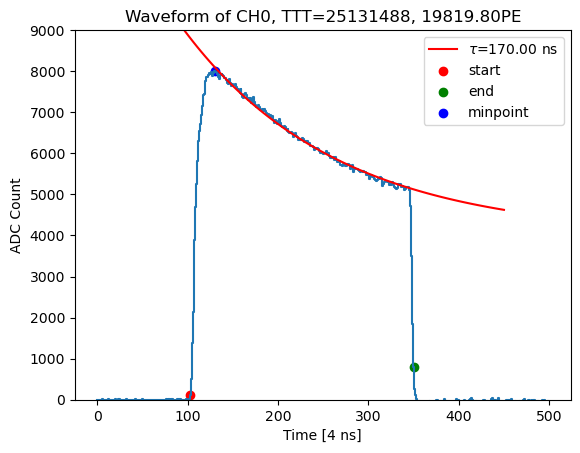

In [128]:
import matplotlib.pyplot as plt
plt.figure()
plt.step(np.arange(len(wave_array)), wave_array, where='mid')
plt.plot(x,  y, label=r'$\tau$={:.2f} ns'.format(tau), color='r', alpha=1)
#plt.plot(x,  y1, label=r'$\tau$={:.2f} ns'.format(165), color='g', alpha=1)
# plt.axhline(y=baseline, color='b', linestyle='--', label='Baseline')  # 基线
# plt.axhline(y=baseline -20, color='r', linestyle='--', label='Threshold')  # 阈值
plt.scatter(st, wave_array[st], color='r', marker='o', label='start')  # 起始点
plt.scatter(ed, wave_array[ed], color='g', marker='o', label='end')  # 结束点
plt.scatter(mp, wave_array[mp], color='b', marker='o', label='minpoint')  # 最低点
plt.title(r'Waveform of CH{}, TTT={}, {:.2f}PE'.format(ch, ttt, area))
plt.xlabel('Time [4 ns]')
plt.ylabel('ADC Count')
plt.legend()
#plt.xlim(xmin, xmax)
plt.ylim(0,9000)
plt.show()

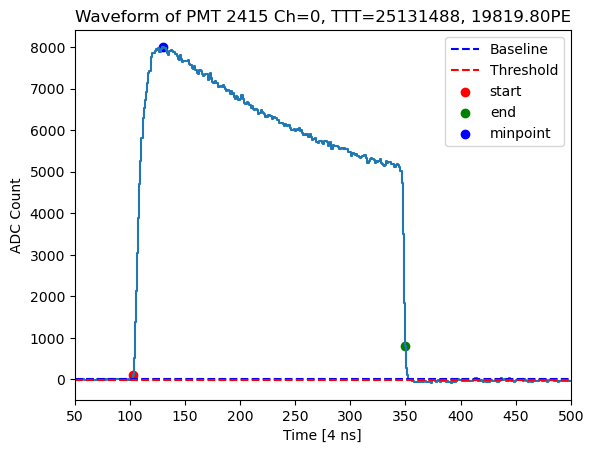

In [125]:
analysis_data.plot_waveform(wave_array, 0, st, ed, mp, 50,500, pmt='2415',ch=r'Ch={}'.format(ch), ttt=ttt, area=area)